In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from sklearn.metrics import roc_auc_score
from torchvision.models import *

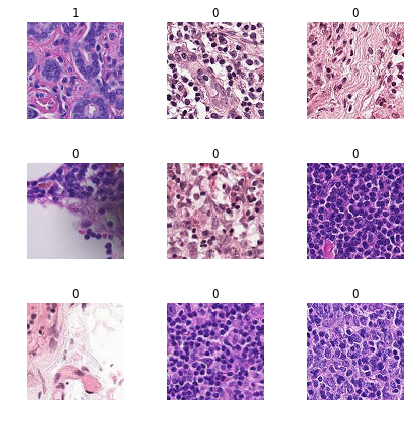

In [3]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)
#tfms = get_transforms(xtra_tfms=cutout())

data = ImageDataBunch.from_csv('.', csv_labels='../input/labels.csv', size=96, ds_tfms=tfms, folder='../input/train', test='../input/test', suffix='.tif', bs=128) #ds_tfms=tfms, 
#data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(6,6))

In [4]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [5]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 3, 96, 96]), torch.Size([128]))

In [48]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [49]:
model = nn.Sequential(
    conv(3, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 2), # 1
    nn.BatchNorm2d(2),
    Flatten()     # remove (1,1) grid
)

In [50]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [51]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 48, 48]     224        True      
______________________________________________________________________
BatchNorm2d          [128, 8, 48, 48]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 48, 48]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 24, 24]    1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 24, 24]    32         True      
______________________________________________________________________
ReLU                 [128, 16, 24, 24]    0          False     
______________________________________________________________________
Conv2d               [128, 32, 12, 12]    4640       True      
______________________________________________________________

In [52]:
xb.shape,yb.shape

(torch.Size([128, 3, 96, 96]), torch.Size([128]))

In [53]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


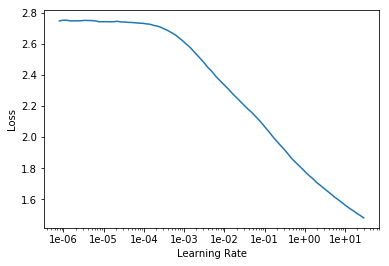

In [54]:
learn.recorder.plot() 

In [55]:
learn.fit_one_cycle(3, max_lr=1)

epoch,train_loss,valid_loss,accuracy
1,0.815147,1.007024,0.598296
2,0.807036,0.820764,0.636905
3,0.772475,0.753240,0.671037


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [56]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [58]:
model = nn.Sequential(
    conv2(3, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 2), # 1
    Flatten()      # remove (1,1) grid
)

In [59]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [60]:
learn.fit_one_cycle(10, max_lr=1)

epoch,train_loss,valid_loss,accuracy
1,0.777692,0.979214,0.602727
2,0.789431,0.997483,0.598023
3,0.828672,1.486657,0.644495
4,0.821918,1.585307,0.602704
5,0.828015,2.269897,0.575548
6,0.811461,1.011099,0.571208
7,0.805936,7.219597,0.532258
8,0.778392,0.864243,0.658743
9,0.764043,0.818473,0.643972
10,0.723722,0.736942,0.679900


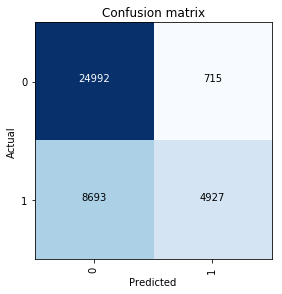

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
preds_t,_ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
def submit(name, sample_file, learn, preds_t):
    sample_ds = pd.read_csv(sample_file).set_index('id')
    clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
    fname=clean_fname(learn.data.test_ds.items) #(data.test_ds.items) learn.data.test_ds.fnames
    fname=fname.astype(str)
    sample_ds.loc[fname,'label']=to_np(preds_t[:,1])
    sample_ds.to_csv(name)
    !kaggle competitions submit -c histopathologic-cancer-detection -f {name} -m "{name}"

In [ ]:
submit('HCD_2.csv', path/'sample_submission.csv', learn, preds_t)

## The END